In [46]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from gym.envs.registration import register
import random

In [1]:
import gym
env = gym.make('CartPole-v0')
env.reset()

random_episodes = 0
reward_sum = 0

while random_episodes < 10:
    env.render()
    action = env.action_space.sample()
    state, reward, done, _ = env.step(env.action_space.sample())
    #print(state, reward, done)
    reward_sum += reward
    
    if done:
        random_episodes += 1
        print('Reward for this episode was:', reward_sum)
        reward_sum = 0
        env.close()
        env.reset()

Reward for this episode was: 21.0
Reward for this episode was: 13.0
Reward for this episode was: 10.0
Reward for this episode was: 11.0
Reward for this episode was: 28.0
Reward for this episode was: 11.0
Reward for this episode was: 16.0
Reward for this episode was: 13.0
Reward for this episode was: 28.0
Reward for this episode was: 53.0


# Q-network

In [20]:
import numpy as np
import torch
import torch.nn as nn



In [112]:
input_dim = env.observation_space.shape[0]
hidden_dim = 16
output_dim = env.action_space.n

In [113]:
class QNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(QNetwork, self).__init__()     
        
        self.lin = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Linear(hidden_dim, output_dim)
        )
        
    def convert_to_tensor(sefl, x):
        return torch.tensor(x, dtype=torch.float)

    def forward(self, state):
        if type(state) != torch.tensor:
            state = self.convert_to_tensor(state)
            
        state.unsqueeze_(0)
        out = self.lin(state)
        
        return out

In [114]:
q_net = QNetwork(input_dim, hidden_dim, output_dim)

q_net

QNetwork(
  (lin): Sequential(
    (0): Linear(in_features=4, out_features=16, bias=True)
    (1): Linear(in_features=16, out_features=2, bias=True)
  )
)

In [118]:
#Q = torch.zeros([env.observation_space.n, env.action_space.n])

reward_ls = []
num_episodes = 2000

criterion = torch.nn.MSELoss()
optim = torch.optim.Adam(q_net.parameters())

loss_ls = []
    
for i in range(num_episodes):    
    s = env.reset()
    r_all = 0
    e_rate = 1. / ((i/100)+1)  # exploration rate (random action)
    disc = 0.99
    alpha = 0.1
    n_step = 0
    done = False
    
    while not done:
        n_step += 1
        
        # Choose an action by e-greedy
        Q_pred = q_net(s)
        Q_target = Q_pred.clone()
        
        if np.random.rand(1) < e_rate :
            a = env.action_space.sample()
        else:
            a = torch.argmax(Q_pred).item()
        
        s_new, r, done, _ = env.step(a)
        
        if done: #경기 종료
            Q_target[0,a] = -500
        else:
            Q_target1 = q_net(s_new)
            #Q_true[0,a] = (1-alpha)*Q_true[0,a].clone() + alpha*(r + disc*torch.max(Q_true1))
            Q_target[0, a] = r + disc*torch.max(Q_target1)
            
        loss = criterion(Q_pred, Q_target)
        loss_ls.append(loss.item())
        
        optim.zero_grad()
        loss.backward()
        optim.step()
                
        r_all += r
        s = s_new
        
    reward_ls.append(n_step)
    
    if i%100 == 0:
        print(n_step)

16
12
11
9
16
152
20
12
35
15
10
9
11
10
10
11
11
9
12
8


In [119]:
np.mean(reward_ls)

12.4845

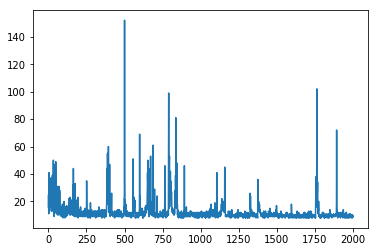

In [120]:
plt.plot(reward_ls)

## Doesn't Converge

### due to 
 - non-stationary target
 - correlation between samples